## Imports

In [1]:
# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Data Split and Cross Validation
from sklearn.model_selection import train_test_split,cross_val_score

# ML Models
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim

# Evaluation Metrics and Model Selection
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterGrid

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance
import shap

# Utility Functions
import random
from utils import *

c:\Users\amoha\anaconda3\envs\cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("data/Final.csv").round(4)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,HOMA_IR,Glucose_BMI_Interact,Age_Insulin_Interact,Age_BMI_Interact,Age_Pregnancies_Interact,Insulin_skin_Interact,SkinThickness_to_BMI_Ratio,Family_History,BloodPressure_Category,Age_Group,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,0.0000,4972.8,0.0,1680.0,300.0,0.0,1176.0,0.0,2.0,2.0,1.0
1,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,0.0000,4263.9,0.0,745.6,256.0,0.0,0.0,0.0,2.0,1.0,1.0
2,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,20.6568,2500.9,1974.0,590.1,21.0,2162.0,646.3,0.0,0.0,1.0,0.0
3,3.0,78.0,50.0,32.0,88.0,31.0,0.248,26.0,16.9481,2418.0,2288.0,806.0,78.0,2816.0,992.0,0.0,0.0,1.0,1.0
4,2.0,197.0,70.0,45.0,543.0,30.5,0.158,53.0,264.1259,6008.5,28779.0,1616.5,106.0,24435.0,1372.5,0.0,2.0,2.0,1.0


In [3]:
X = df.drop(columns="Outcome").values
y = df["Outcome"].values

data = df.drop(columns="Outcome")

## Data Split



**Improved Generalisation through Separate Normalisation**


Normalising the training and validation data separately can improve model generalization in a few ways:

1. **Prevents Data Leakage**: Separately normalising training and validation data prevents information leakage from the validation set into the training process, reducing the risk of overfitting.

2. **Reflects Real-World Variation**: By adapting to the specific characteristics of each dataset, separate normalisation better prepares the model for unseen data with potentially different distributions.

3. **Enhanced Stability**: Separate normalisation ensures that each dataset is scaled appropriately, leading to a more stable training process and better convergence.



In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

### Z-score Normalisation

This technique scales the values of a feature to have a mean of 0 and a standard deviation of 1. This is done by subtracting the mean of the feature from each value, and then dividing by the standard deviation.

In [5]:
# Calculate means and standard deviations
X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)

X_test_mean = np.mean(X_test, axis=0)
X_test_std = np.std(X_test, axis=0)

X_val_mean = np.mean(X_val, axis=0)
X_val_std = np.std(X_val, axis=0)

# Z-score Normalization of train, validation, and test sets
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_val_mean) / X_val_std
X_test = (X_test - X_test_mean) / X_test_std

## Model Implementation

In [6]:
num_folds = 5

# Define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=10000),
    "SVM": svm.SVC(random_state=0),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "RandomFC": RandomForestClassifier(random_state=42)
}

# Cross-validate and train classifiers
cv_scores = {}
test_scores = {}
for name, clf in classifiers.items():
    cv_scores[name] = cross_val_score(clf, X_train, y_train.ravel(), cv=num_folds).mean()
    clf.fit(X_train, y_train)
    test_scores[name] = clf.score(X_test, y_test)

# Find the best model based on cross-validation scores
best_model = max(cv_scores.items(), key=lambda x: x[1])

print(f"Best model based on cross-validation: {best_model[0]}")
print(f"Cross-validation accuracy: {cv_scores[best_model[0]]}")

# Test the best model on the test set
print(f"Test accuracy with {best_model[0]}: {test_scores[best_model[0]]}")


Best model based on cross-validation: RandomFC
Cross-validation accuracy: 0.8911690688629603
Test accuracy with RandomFC: 0.9183673469387755


Based on the printout above, it's evident that the random forest model has achieved the highest cross-validation accuracy. Additionally, the model has demonstrated robust performance on unseen data, with a test accuracy of approximately 92%. To gain deeper insights into the model's behavior and understand the importance of different features, we will employ the SHAP (SHapley Additive exPlanations) technique. SHAP will enable us to examine the impact of each feature on model predictions and provide valuable insights into the model's decision-making process.

### SHapley Additive exPlanations(SHAP)

SHapley Additive exPlanations (SHAP) is a unified framework for explaining the output of any machine learning model. It provides a comprehensive explanation of individual predictions by attributing the model's output to different input features.

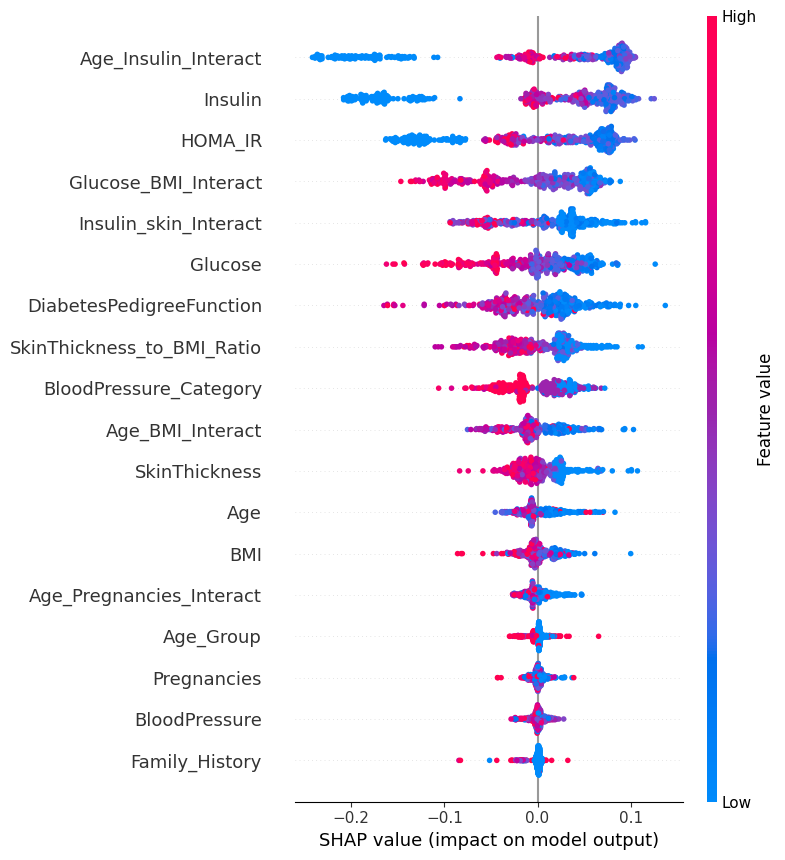

In [7]:
best_model_name = best_model[0]
best_model_object = classifiers[best_model_name]

# Train the best model on the entire training set
best_model_object.fit(X_train, y_train)

# Use SHAP to explain model predictions
explainer = shap.TreeExplainer(best_model_object)
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot
shap.summary_plot(shap_values[:,:,0], X_train, feature_names=np.array(df.columns.drop("Outcome")))

The SHAP summary plot reveals the influential features driving our model's predictions. Notably, Low Insulin values and low interaction between age and Insulin values exhibit substantial influence, while features like family history and number of pregnancies have minimal impact. Discarding these less impactful features can effectively reduce computational costs without compromising the model's predictive performance.

## Deep Learning

In this section, we'll explore the application of a sequential model, a simple multilayer perceptron, to assess its suitability for our task. While this approach might be considered overkill for this dataset, given that a random forest model has already achieved an accuracy of 92%, it offers insights into the potential performance and capabilities of deep learning methods for this application.

In [8]:
# Sequential Model

def create_model(n1, n2,num_features):
    model = nn.Sequential(
        nn.Linear(num_features, n1),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(n1, n2),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(n2, 1),
        nn.Sigmoid()
    )
    return model

### PyTorch tensors


In [9]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)


y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

### CUDA

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training

In [11]:
# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

param = {'batch_size': 32, 'lr': 0.001, 'n1': 32, 'n2': 64}
model = create_model(param["n1"], param['n2'], X_train.shape[1]).to(device)

loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=param['lr'])

train, validation, test = train_model(model, X_train, y_train, X_val, y_val, X_test, y_test, optimizer, loss_fn)


Epoch [1/100], Train Loss: 0.6715, Val Loss: 0.6321, Test Loss: 0.6249, Train Accuracy: 0.7030, Val Accuracy: 0.6987, Test Accuracy: 0.7194
Epoch [2/100], Train Loss: 0.5750, Val Loss: 0.5656, Test Loss: 0.5549, Train Accuracy: 0.7350, Val Accuracy: 0.7628, Test Accuracy: 0.7500
Epoch [3/100], Train Loss: 0.4459, Val Loss: 0.4967, Test Loss: 0.4886, Train Accuracy: 0.7671, Val Accuracy: 0.7660, Test Accuracy: 0.7959
Epoch [4/100], Train Loss: 0.3576, Val Loss: 0.4328, Test Loss: 0.4312, Train Accuracy: 0.7927, Val Accuracy: 0.7949, Test Accuracy: 0.8316
Epoch [5/100], Train Loss: 0.3479, Val Loss: 0.3895, Test Loss: 0.3915, Train Accuracy: 0.8162, Val Accuracy: 0.8365, Test Accuracy: 0.8469
Epoch [6/100], Train Loss: 0.1997, Val Loss: 0.3655, Test Loss: 0.3616, Train Accuracy: 0.8440, Val Accuracy: 0.8494, Test Accuracy: 0.8469
Epoch [7/100], Train Loss: 0.2325, Val Loss: 0.3499, Test Loss: 0.3392, Train Accuracy: 0.8440, Val Accuracy: 0.8462, Test Accuracy: 0.8724
Epoch [8/100], Train

## Model Performance Evaluation

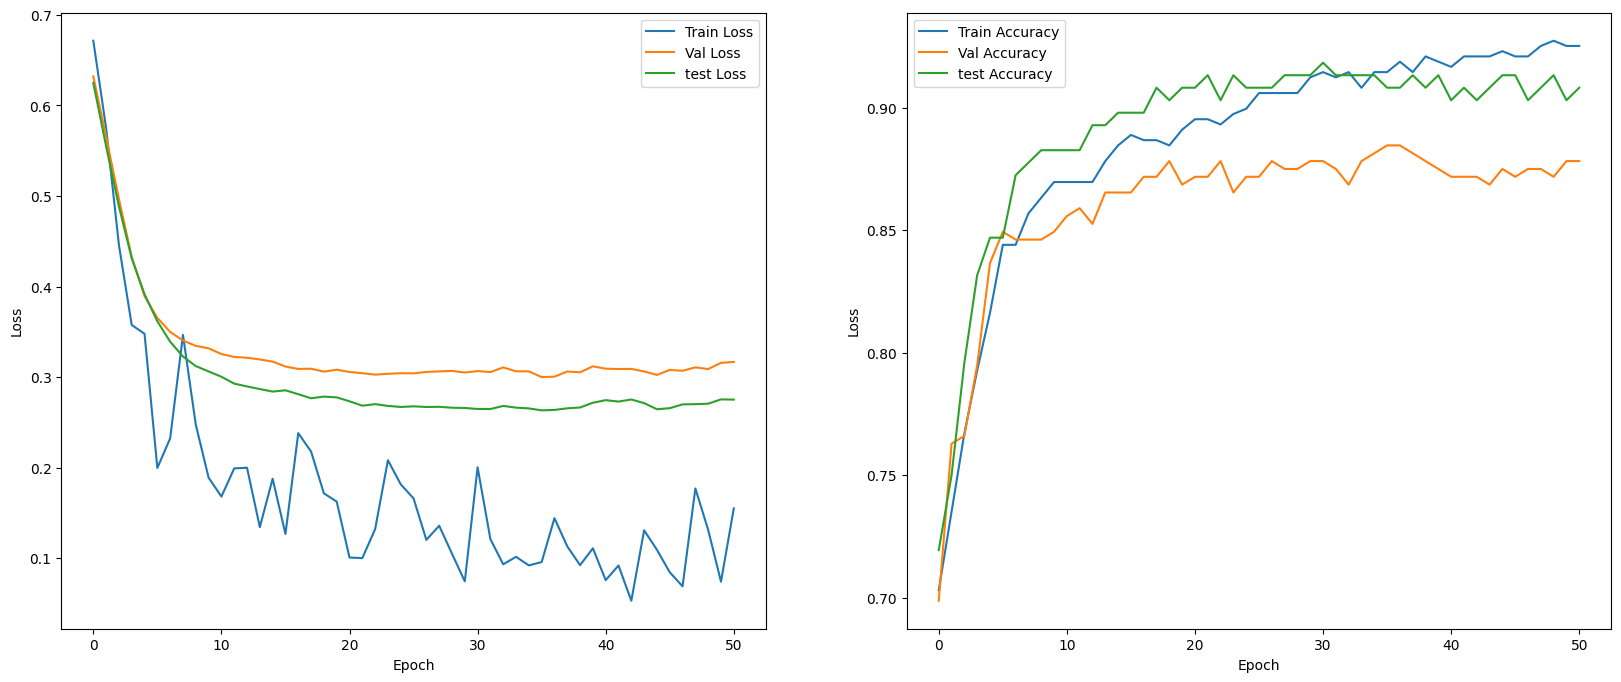

In [12]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(train["Loss"][0], label='Train Loss')
plt.plot(validation["Loss"][0], label='Val Loss')
plt.plot(test["Loss"][0], label='test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train["Accuracy"][0], label='Train Accuracy')
plt.plot(validation["Accuracy"][0], label='Val Accuracy')
plt.plot(test["Accuracy"][0], label='test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Confusion Matrix - Training Set:


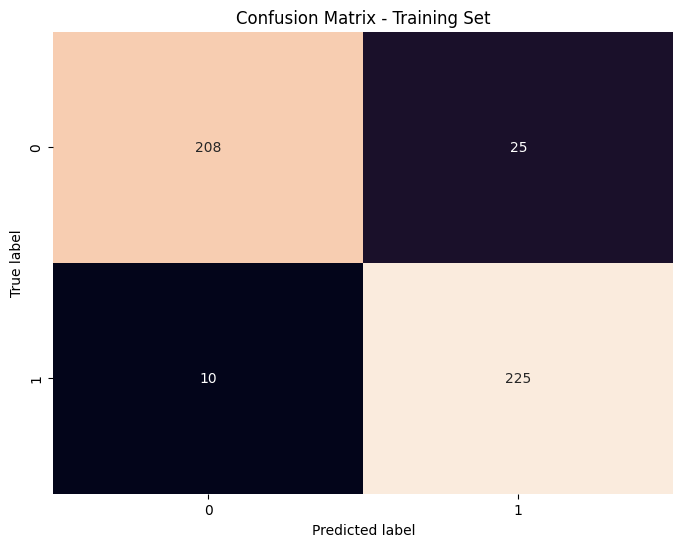

Confusion Matrix - Validation Set:


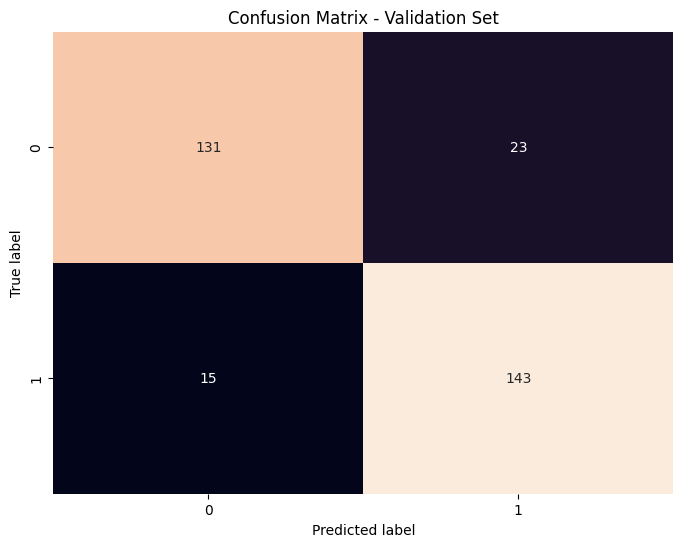

Confusion Matrix - Test Set:


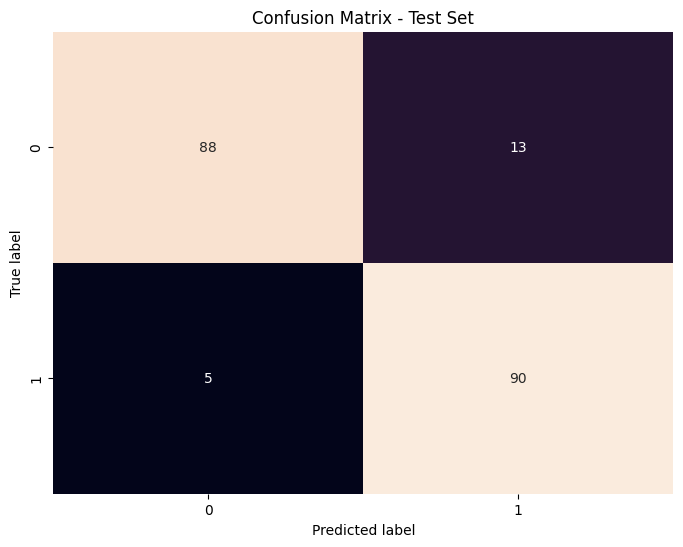

In [13]:
print("Confusion Matrix - Training Set:")
plot_confusion_matrix(train["cm"][0], title='Confusion Matrix - Training Set')

print("Confusion Matrix - Validation Set:")
plot_confusion_matrix(validation["cm"][0], title='Confusion Matrix - Validation Set')

print("Confusion Matrix - Test Set:")
plot_confusion_matrix(test["cm"][0], title='Confusion Matrix - Test Set')


The multi-layer perceptron (MLP) has achieved an average accuracy of 90% on the validation and test datasets. However, it's worth noting that the model appears to be overfitting after epoch 30, as the training accuracy surpasses that of other datasets. Nonetheless, there is only a slight discrepancy between the training accuracy and those of other datasets, suggesting that the model is generalising well. In the next section, we will delve into analysing the feature importance to gain deeper insights into the model's behaviour and decision-making process.

## Feature Importance

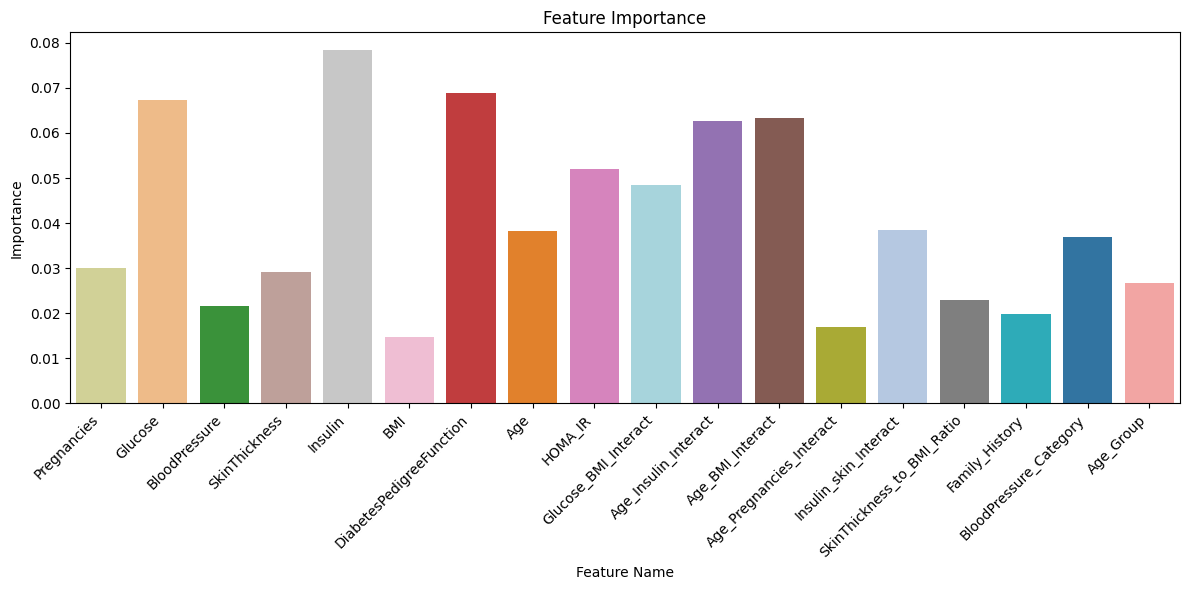

In [14]:
# Calculate feature importance
feature_importance = calculate_feature_importance(model, X_train)


# Assuming you have already defined feature_names and feature_importance

palette1 = sns.color_palette("tab10", n_colors=10)
palette2 = sns.color_palette("tab20", n_colors=20)

# Combine the two palettes to get 18 distinct colors
colors = list(set(palette1 + palette2))

plt.figure(figsize=(12, 6))  # Increase the width of the figure
ax = sns.barplot(x=data.columns, y=feature_importance, palette=colors[:18],hue = data.columns)

plt.xlabel('Feature Name')
plt.ylabel('Importance')
plt.title('Feature Importance')

# Rotate x-axis labels to an angle for better readability
ax.set_xticks(range(len(data.columns)))
ax.set_xticklabels(data.columns, rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to improve spacing
plt.show()

The analysis of feature importance for our MLP model reveals that insulin is the most influential feature, followed by diabetes pedigree function in second place, and glucose in third. Conversely, BMI and the interaction between age and pregnancies are identified as the least influential features. This understanding provides valuable insights into which features are driving the model's predictions and can guide further analysis and model refinement.

 This insight into feature importance enables us to streamline our model by focusing only on the most influential features. By incorporating solely these significant features, we can effectively reduce computational complexity and the time required for training. Consequently, this streamlined approach will yield a faster and simpler model without significantly compromising accuracy.

In [15]:
importance_dict = {'importance':feature_importance,'feature':data.columns}

# Create a dictionary where keys are feature names and values are importance scores
feature_importance_dict = dict(zip(importance_dict['feature'], importance_dict['importance']))

# Sort the dictionary by importance scores in descending order
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Select the top features with the highest importance scores
top10_features = sorted_features[:10] 

# Print the top features
print("Top features with highest importance:")
for feature, importance in top10_features:
    print(f"{feature}: {importance}")


Top features with highest importance:
Insulin: 0.07841818034648895
DiabetesPedigreeFunction: 0.06885302811861038
Glucose: 0.06732325255870819
Age_BMI_Interact: 0.06328386813402176
Age_Insulin_Interact: 0.062660351395607
HOMA_IR: 0.05190108343958855
Glucose_BMI_Interact: 0.04834560304880142
Insulin_skin_Interact: 0.03840949758887291
Age: 0.03825860098004341
BloodPressure_Category: 0.03698199242353439


## Hyper Parameter Tuning (Grid Search)
By systematically exploring various hyperparameter combinations, grid search helps us identify the optimal configuration for our model, leading to improved performance and better generalisation.



### Grid Search Parameters
- **Batch Size**: We will experiment with batch sizes of 8, 16, 32, and 64.
- **Learning Rate (lr)**: We will evaluate learning rates of 0.001, 0.01, and 0.1.
- **Hidden Layer Sizes (n1 and n2)**: We will vary the number of neurons in the two hidden layers with options of 16, 32, 64 and 128 for each layer.


In [19]:
# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Define the grid search parameters
grid_params = {
    'batch_size': [8, 16, 32, 64],
    'lr': [0.001, 0.01, 0.1],
    'n1': [16, 32, 64, 128],
    'n2': [16, 32, 64, 128]
}

X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

best_params = grid_search(X_train, y_train, X_val, y_val, X_test, y_test, grid_params)

best_val_loss = float('inf')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = create_model(best_params['param']["n1"], best_params['param']['n2'], 18)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params['param']['lr'])
train, validation, test = train_model(model, X_train, y_train, X_val, y_val, X_test, y_test, optimizer, loss_fn)

print("\nBest Parameters:", best_params)




Early stopping at epoch 47 for parameter combination: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 32}

Parameters: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 32}, Best Validation Loss: 0.3002, Val_acc: 0.875 at epoch 27

Early stopping at epoch 20 for parameter combination: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 64}

Parameters: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 64}, Best Validation Loss: 0.3002, Val_acc: 0.8589743971824646 at epoch 27

Early stopping at epoch 20 for parameter combination: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 128}

Parameters: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 128}, Best Validation Loss: 0.3002, Val_acc: 0.8621795177459717 at epoch 27

Early stopping at epoch 20 for parameter combination: {'batch_size': 8, 'lr': 0.001, 'n1': 32, 'n2': 32}

Parameters: {'batch_size': 8, 'lr': 0.001, 'n1': 32, 'n2': 32}, Best Validation Loss: 0.3002, Val_acc: 0.8782051205635071 at epoch 27

Early stopping at epoch 41 for parameter combi

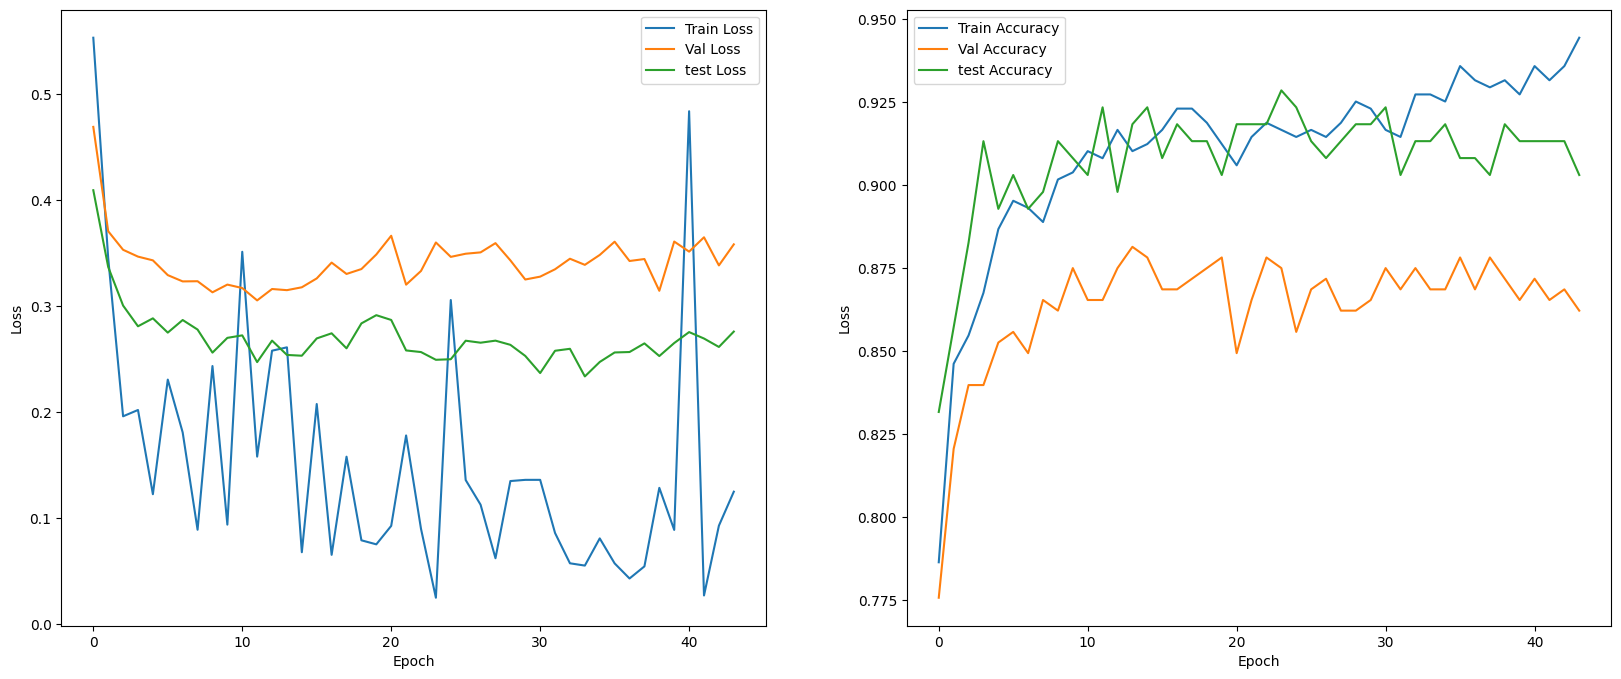

In [20]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(train["Loss"][0], label='Train Loss')
plt.plot(validation["Loss"][0], label='Val Loss')
plt.plot(test["Loss"][0], label='test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train["Accuracy"][0], label='Train Accuracy')
plt.plot(validation["Accuracy"][0], label='Val Accuracy')
plt.plot(test["Accuracy"][0], label='test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Confusion Matrix - Training Set:


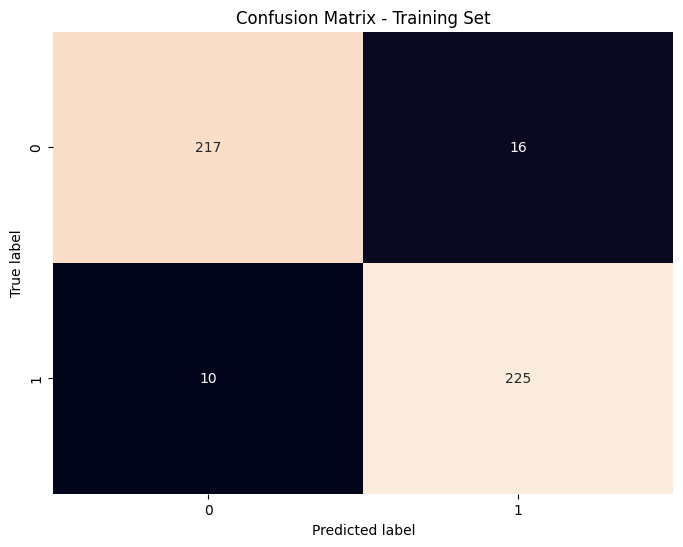

Confusion Matrix - Validation Set:


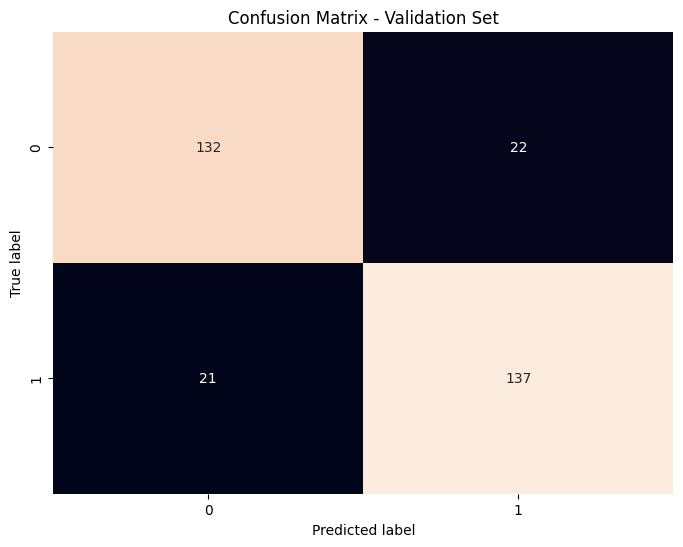

Confusion Matrix - Test Set:


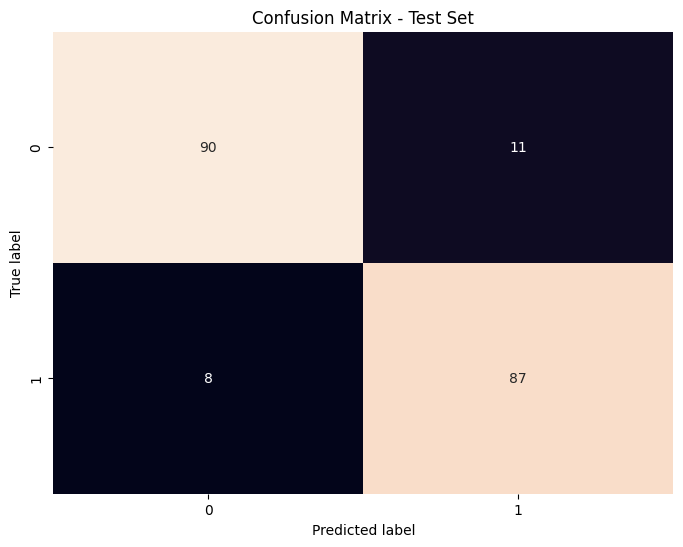

In [21]:
print("Confusion Matrix - Training Set:")
plot_confusion_matrix(train["cm"][0], title='Confusion Matrix - Training Set')

print("Confusion Matrix - Validation Set:")
plot_confusion_matrix(validation["cm"][0], title='Confusion Matrix - Validation Set')

print("Confusion Matrix - Test Set:")
plot_confusion_matrix(test["cm"][0], title='Confusion Matrix - Test Set')


**observations**
